In [3]:
import os
import yaml
import numpy as np
from math import sqrt,log10
import pylab as plt
import corner

from scipy.optimize import brentq, fmin
from scipy.interpolate import interp1d as interp
from scipy.interpolate import UnivariateSpline as spline
from sklearn.model_selection import LeaveOneOut

%matplotlib inline

In [5]:
J, L, a, b, c, r = np.load('results/MCtest.npy')

In [7]:
indLmin = np.where( L==min(L) )[0][0]
Lmin = L[indLmin]

for p in ['J', 'a', 'b', 'c', 'r']:
    exec('{p}min = {p}[indLmin]'.format(p=p))

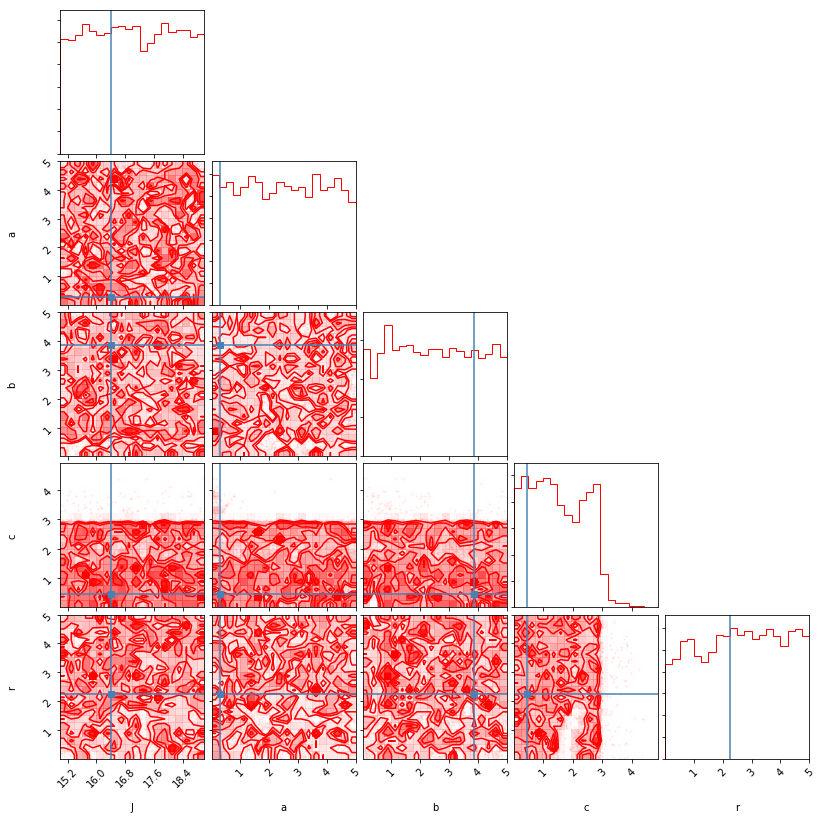

In [10]:
samples = np.vstack([J, a, b, c, r]).T

tmp = corner.corner(samples[:,:], labels=['J', 'a', 'b', 'c', 'r'], color='r', truths=[Jmin, amin, bmin, cmin, rmin])
#plt.suptitle( 'corner plots J = 16, 10000 MCMC points', fontsize=12 );
#plt.savefig( 'results/cornerJ16.png', dpi=300, format='png' );